In [1]:
import argparse
import numpy as np
import torch
import datetime
import json
import yaml
import os
import datetime as dt
import pandas as pd

from main_model import Score_Based_Diffusion
from dataset_forecasting import get_dataloader, get_test_dataloader
from utils import train, evaluate

import seaborn
import pickle
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, multivariate_normal, norm
import sys
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from visualization_one_result import plot_density, plot_QQ, plot_log_tail_distn, calc_and_print_VAR

In [2]:
def load_generated_data_diffusion_bike(datafolder):
    nsample = 1 # number of generated sample

    path = './save/'+datafolder+"/generated_outputs_nsample_" + str(nsample) + '.pk' 
    with open(path, 'rb') as f:
        samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load(f)

    all_target=(all_target * scaler + mean_scaler) # real data
    samples=(samples.squeeze(1) * scaler + mean_scaler) # generated data
    samples = all_target*(1-all_evalpoint)+samples*all_evalpoint # for generated data, replace the condition part by real data

    all_target = all_target.cpu().numpy()
    samples = samples.cpu().numpy()

    return all_target, samples

In [3]:
all_target, t_samples = load_generated_data_diffusion_bike("bike_uncond_SHD_new2")
_, gaussian_samples = load_generated_data_diffusion_bike("bike_uncond_SGM_new")

In [4]:


pivot_data = pd.read_csv("data/bike/pivot_data.csv",index_col=[0])
real_paths = []
results_dict = {"t":{},"gaussian":{}}
for starting_value in {tuple(row) for row in all_target[:,0:12,0]}:

    target_subset = np.array([row for row in all_target if np.array_equal(row[0:12,0], starting_value)])

    # target_mask = (all_target[:, 0:12, 0] == starting_value)
    # target_subset = all_target[target_mask]
    # print(target_subset.shape)

    t_samples_subset = np.array([row for row in t_samples if np.array_equal(row[0:12,0], starting_value)])
    # t_samples_mask = (t_samples[:, 0:12, 0] == starting_value)
    # t_samples_subset = t_samples[t_samples_mask]

    gaussian_samples_subset = np.array([row for row in gaussian_samples if np.array_equal(row[0:12,0], starting_value)])
    # gaussian_samples_mask = (gaussian_samples[:, 0, 0] == starting_value)
    # gaussian_samples_subset = gaussian_samples[gaussian_samples_mask]

    real_path = []
    quantile_95_path_t = []
    quantile_75_path_t = []
    quantile_25_path_t = []
    quantile_05_path_t = []

    quantile_95_path_gaussian = []
    quantile_75_path_gaussian = []
    quantile_25_path_gaussian = []
    quantile_05_path_gaussian = []

    for time in range(t_samples_subset.shape[1]):
        real_path.append(target_subset[0][time][0])
        quantile_95_path_t.append(np.percentile(t_samples_subset[:,time,0],95))
        quantile_75_path_t.append(np.percentile(t_samples_subset[:,time,0],75))
        quantile_25_path_t.append(np.percentile(t_samples_subset[:,time,0],25))
        quantile_05_path_t.append(np.percentile(t_samples_subset[:,time,0],5))

        quantile_95_path_gaussian.append(np.percentile(gaussian_samples_subset[:,time,0],95))
        quantile_75_path_gaussian.append(np.percentile(gaussian_samples_subset[:,time,0],75))
        quantile_25_path_gaussian.append(np.percentile(gaussian_samples_subset[:,time,0],25))
        quantile_05_path_gaussian.append(np.percentile(gaussian_samples_subset[:,time,0],5))
    real_paths.append(real_path)

    # find today's date
    
    target_series = pd.Series(np.array(real_path), index=pivot_data.columns)

    # Find the row(s) where all values match the target
    matches = (abs(pivot_data - target_series)<0.1).all(axis=1)

    # Get the index of matching row(s)
    matching_indexes = matches[matches].index.tolist()
    today = matching_indexes[0]

    results_dict["t"][today] = {"real_path":real_path, "fake_paths":t_samples_subset, "quantile_05_path":quantile_05_path_t, "quantile_25_path":quantile_25_path_t,\
                           "quantile_75_path":quantile_75_path_t, "quantile_95_path":quantile_95_path_t}
    results_dict["gaussian"][today] = {"real_path":real_path, "fake_paths":gaussian_samples_subset, "quantile_05_path":quantile_05_path_gaussian, "quantile_25_path":quantile_25_path_gaussian,\
                           "quantile_75_path":quantile_75_path_gaussian, "quantile_95_path":quantile_95_path_gaussian}





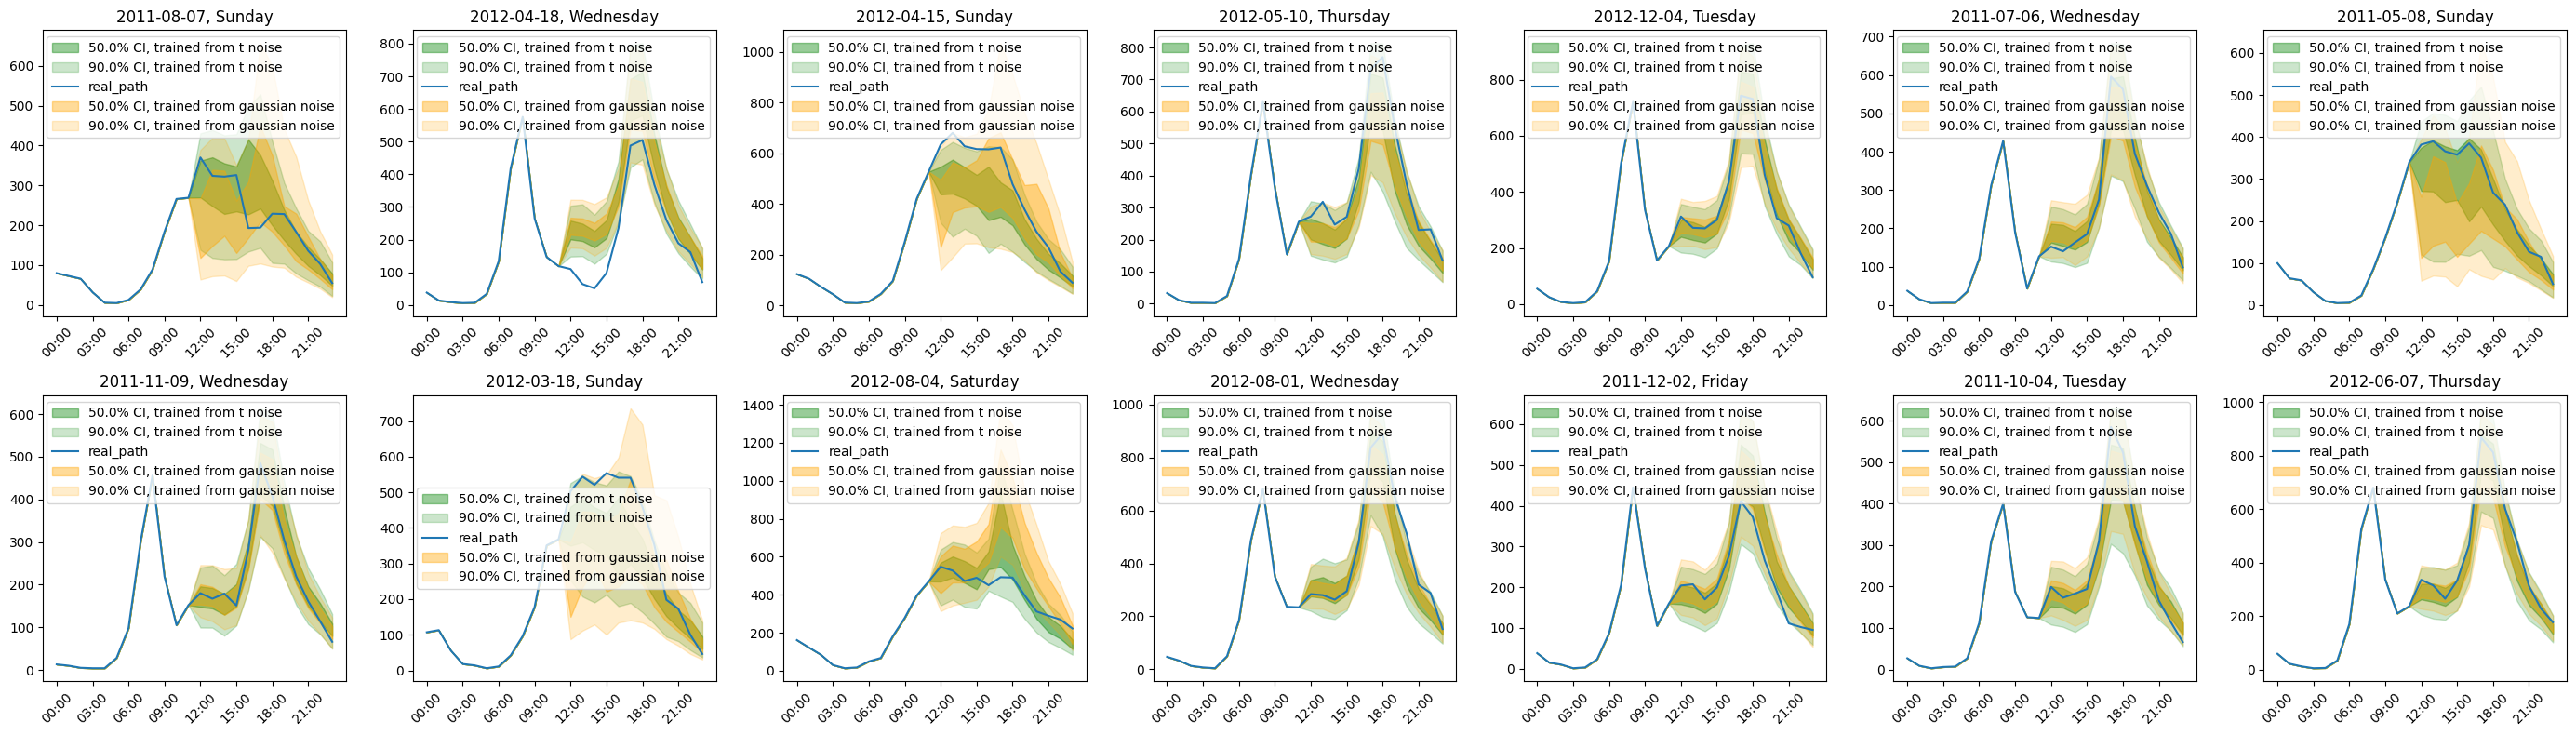

In [5]:
fig, axes = plt.subplots(2, 7, figsize = (4*7, 4*2))  # Adjust the figsize to fit your screen
k=0
axes = np.array(axes).reshape(7,2)
color_map = {"t":"green", "gaussian":"orange"}
for today in results_dict["t"].keys():
    ax = axes[k//2,k%2]
    k+=1
    real_path = results_dict["t"][today]["real_path"]
    for key in ["t","gaussian"]:
        quantile_05_path = results_dict[key][today]["quantile_05_path"]
        quantile_25_path = results_dict[key][today]["quantile_25_path"]
        quantile_75_path = results_dict[key][today]["quantile_75_path"]
        quantile_95_path = results_dict[key][today]["quantile_95_path"]
        time = [f"{'%02d'%i}:00" for i in range(24)]
        ax.fill_between(time, quantile_25_path, quantile_75_path, color=color_map[key], alpha=0.4, label=f'50.0% CI, trained from {key} noise')
        ax.fill_between(time, quantile_05_path, quantile_95_path, color=color_map[key], alpha=0.2, label=f'90.0% CI, trained from {key} noise')
        if key == "t":
            ax.plot(time, real_path, label = "real_path")

    ax.set_xticks(time[::3])  # Setting x-ticks to show every 2 hours for clarity
    ax.set_xticklabels(time[::3], rotation=45)  # Rotate labels for better readability
    ax.legend()
    
    ax.set_title(today+", "+dt.datetime.strptime(today, "%Y-%m-%d").strftime("%A"))
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area
plt.savefig('save/plot_result/time_plot.png')
plt.show()


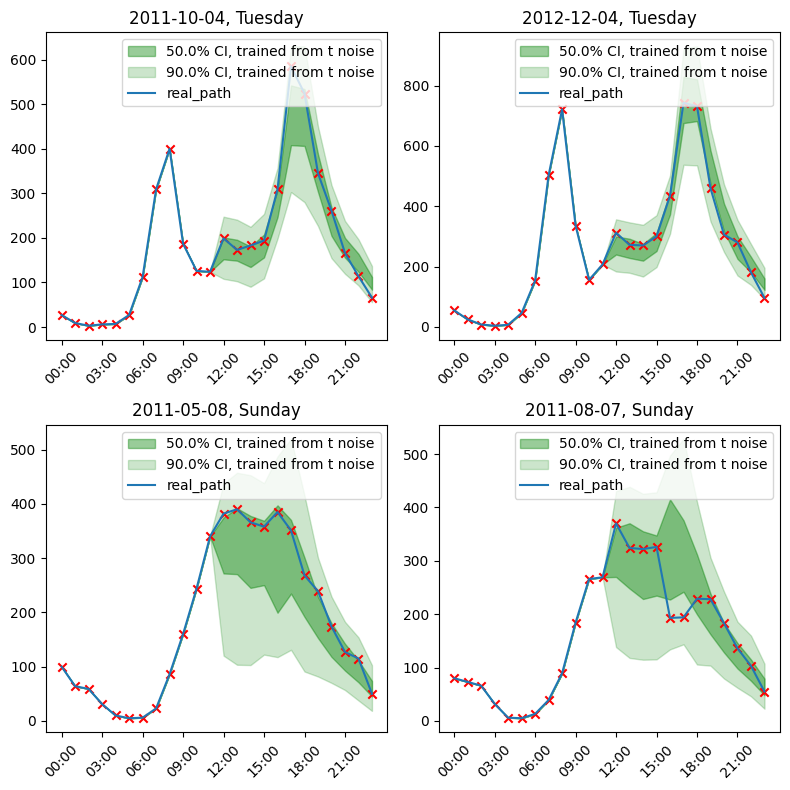

In [42]:
fig, axes = plt.subplots(2, 2, figsize = (4*2, 4*2))  # Adjust the figsize to fit your screen
k=0
axes = np.array(axes).reshape(2,2)
color_map = {"t":"green", "gaussian":"orange"}
for today in ["2011-10-04", "2012-12-04", "2011-05-08", "2011-08-07"]:
    ax = axes[k//2,k%2]
    k+=1
    real_path = results_dict["t"][today]["real_path"]
    for key in ["t"]:
        quantile_05_path = results_dict[key][today]["quantile_05_path"]
        quantile_25_path = results_dict[key][today]["quantile_25_path"]
        quantile_75_path = results_dict[key][today]["quantile_75_path"]
        quantile_95_path = results_dict[key][today]["quantile_95_path"]
        time = [f"{'%02d'%i}:00" for i in range(24)]
        ax.fill_between(time, quantile_25_path, quantile_75_path, color=color_map[key], alpha=0.4, label=f'50.0% CI, trained from {key} noise')
        ax.fill_between(time, quantile_05_path, quantile_95_path, color=color_map[key], alpha=0.2, label=f'90.0% CI, trained from {key} noise')
        if key == "t":
            ax.plot(time, real_path, label = "real_path")
            ax.scatter(time, real_path, color="red", marker="x")

    ax.set_xticks(time[::3])  # Setting x-ticks to show every 2 hours for clarity
    ax.set_xticklabels(time[::3], rotation=45)  # Rotate labels for better readability
    ax.legend()
    
    ax.set_title(today+", "+dt.datetime.strptime(today, "%Y-%m-%d").strftime("%A"))
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area
plt.savefig('save/plot_result/bike_rental_plot_t.png')
plt.show()


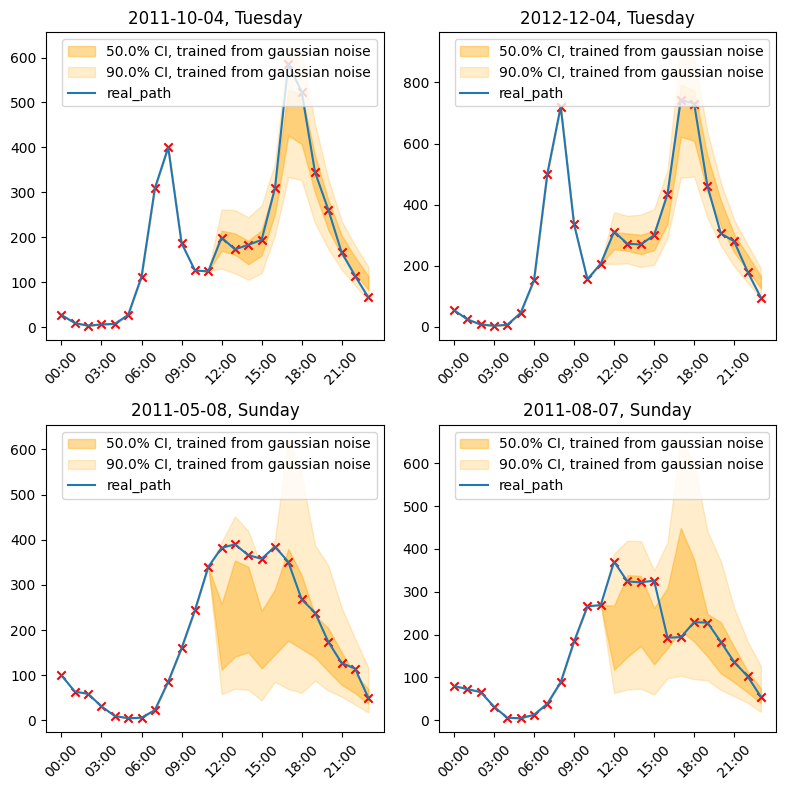

In [41]:
fig, axes = plt.subplots(2, 2, figsize = (4*2, 4*2))  # Adjust the figsize to fit your screen
k=0
axes = np.array(axes).reshape(2,2)
color_map = {"t":"green", "gaussian":"orange"}
for today in ["2011-10-04", "2012-12-04", "2011-05-08", "2011-08-07"]:
    ax = axes[k//2,k%2]
    k+=1
    real_path = results_dict["t"][today]["real_path"]
    for key in ["gaussian"]:
        quantile_05_path = results_dict[key][today]["quantile_05_path"]
        quantile_25_path = results_dict[key][today]["quantile_25_path"]
        quantile_75_path = results_dict[key][today]["quantile_75_path"]
        quantile_95_path = results_dict[key][today]["quantile_95_path"]
        time = [f"{'%02d'%i}:00" for i in range(24)]
        ax.fill_between(time, quantile_25_path, quantile_75_path, color=color_map[key], alpha=0.4, label=f'50.0% CI, trained from {key} noise')
        ax.fill_between(time, quantile_05_path, quantile_95_path, color=color_map[key], alpha=0.2, label=f'90.0% CI, trained from {key} noise')
        if key == "gaussian":
            ax.plot(time, real_path, label = "real_path")
            ax.scatter(time, real_path, color="red", marker="x")

    ax.set_xticks(time[::3])  # Setting x-ticks to show every 2 hours for clarity
    ax.set_xticklabels(time[::3], rotation=45)  # Rotate labels for better readability
    ax.legend()
    
    ax.set_title(today+", "+dt.datetime.strptime(today, "%Y-%m-%d").strftime("%A"))
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area
plt.savefig('save/plot_result/bike_rental_plot_gaussian.png')
plt.show()


In [31]:
def quantile_loss(target, forecast, q: float, eval_points) -> float:
    return 2 * torch.sum(
        abs((forecast - target) * eval_points * ((target <= forecast) * 1.0 - q))
    )


def calc_denominator(target, eval_points):
    return torch.sum(torch.abs(target * eval_points))


def calc_quantile_CRPS(target, forecast, eval_points, mean_scaler=0, scaler=1):

    target = target * scaler + mean_scaler
    forecast = forecast * scaler + mean_scaler

    quantiles = np.arange(0.05, 1.0, 0.05)
    denom = calc_denominator(target, eval_points)
    CRPS = 0
    for i in range(len(quantiles)):
        q_pred = []
        for j in range(len(forecast)):
            q_pred.append(torch.quantile(forecast[j:j+1], quantiles[i], dim=1))
        q_pred = torch.cat(q_pred, 0)
        q_loss = quantile_loss(target, q_pred, quantiles[i], eval_points)
        CRPS += q_loss / denom
    return CRPS.item() / len(quantiles)

In [32]:
CRPS_t_list = []
CRPS_gaussian_list = []

for today in results_dict["t"].keys():
    real = torch.tensor(results_dict["t"][today]["real_path"])
    fake_t = torch.tensor(results_dict["t"][today]["fake_paths"]).reshape(-1,24).T
    fake_gaussian = torch.tensor(results_dict["gaussian"][today]["fake_paths"]).reshape(-1,24).T
    CRPS_t = calc_quantile_CRPS(real,fake_t,torch.tensor([0 for i in range(12)]+[1 for i in range(12)]))
    CRPS_gaussian = calc_quantile_CRPS(real,fake_gaussian,torch.tensor([0 for i in range(12)]+[1 for i in range(12)]))
    CRPS_t_list.append(CRPS_t)
    CRPS_gaussian_list.append(CRPS_gaussian)


In [33]:
weekday_list = []
weekend_list = []
for today in results_dict["t"].keys():
    if dt.datetime.strptime(today, "%Y-%m-%d").strftime("%A") in ["Saturday", "Sunday"]:
        weekend_list.append(today)
    else:
        weekday_list.append(today)

In [34]:
CRPS_t_list_weekday = []
CRPS_gaussian_list_weekday = []

for today in weekday_list:
    real = torch.tensor(results_dict["t"][today]["real_path"])
    fake_t = torch.tensor(results_dict["t"][today]["fake_paths"]).reshape(-1,24).T
    fake_gaussian = torch.tensor(results_dict["gaussian"][today]["fake_paths"]).reshape(-1,24).T
    CRPS_t = calc_quantile_CRPS(real,fake_t,torch.tensor([0 for i in range(12)]+[1 for i in range(12)]))
    CRPS_gaussian = calc_quantile_CRPS(real,fake_gaussian,torch.tensor([0 for i in range(12)]+[1 for i in range(12)]))
    CRPS_t_list_weekday.append(CRPS_t)
    CRPS_gaussian_list_weekday.append(CRPS_gaussian)


In [35]:
CRPS_t_list_weekend = []
CRPS_gaussian_list_weekend = []

for today in weekend_list:
    real = torch.tensor(results_dict["t"][today]["real_path"])
    fake_t = torch.tensor(results_dict["t"][today]["fake_paths"]).reshape(-1,24).T
    fake_gaussian = torch.tensor(results_dict["gaussian"][today]["fake_paths"]).reshape(-1,24).T
    CRPS_t = calc_quantile_CRPS(real,fake_t,torch.tensor([0 for i in range(12)]+[1 for i in range(12)]))
    CRPS_gaussian = calc_quantile_CRPS(real,fake_gaussian,torch.tensor([0 for i in range(12)]+[1 for i in range(12)]))
    CRPS_t_list_weekend.append(CRPS_t)
    CRPS_gaussian_list_weekend.append(CRPS_gaussian)


In [36]:
print(np.array(CRPS_t_list).mean())
print("weekday", np.array(CRPS_t_list_weekday).mean())
print("weekend", np.array(CRPS_t_list_weekend).mean())

0.12707820108958653
weekday 0.11848299336015132
weekend 0.1425495750025699


In [37]:
print(np.array(CRPS_gaussian_list).mean())
print("weekday", np.array(CRPS_gaussian_list_weekday).mean())
print("weekend", np.array(CRPS_gaussian_list_weekend).mean())

0.15892341441677924
weekday 0.12244599325615065
weekend 0.22458277250591077
